# Оценка (до кросс-валидации и optuna-тюнинга)

In [1]:
#Доля тестовых данных
test_size=0.5 

#Доля данных для обучения
train_size=1-test_size

In [2]:
import polars as pl
import pandas as pd


from catboost import Pool, CatBoostClassifier, cv, sum_models

from sklearn.model_selection import train_test_split

import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

In [3]:
pl.Config(fmt_str_lengths=150)
#pl.Config(tbl_rows=40)

In [4]:
%%time
labeled=pl.read_parquet("labeled_train.parquet").with_columns(pl.col("cat_id").cast(pl.Int16))
print(f"{labeled.shape=}")

#Отделение данных для теста
labeled, labeled_test = train_test_split(labeled, test_size=test_size, random_state=42)
print(f"{labeled.shape=}", f"{labeled_test.shape=}")

labeled.shape=(716552, 4)
labeled.shape=(358276, 4) labeled_test.shape=(358276, 4)
CPU times: user 935 ms, sys: 402 ms, total: 1.34 s
Wall time: 1.05 s


In [5]:
%%time

labeled1 = labeled.with_columns((pl.col("attributes").str.slice(3,pl.col("attributes").str.len_chars()-5)
                               ).str.split("},{") )
labeled1

labeled1 = labeled1.explode("attributes"
                         ).with_columns(
    pl.col("attributes").str.extract(r"\"attribute_id\"\"\:(\d+?),", 1).cast(pl.Int16).alias("attr_id"),
    pl.col("attributes").str.extract(r"\"\"attribute_name\"\":\"\"(.+?)\"\"", 1).alias("attr_name"),
    pl.col("attributes").str.extract(r"\"\"attribute_value\"\":\"\"(.+?)\"\"", 1).alias("attr_value"),
    pl.col("attributes").str.extract(r"\"\"attribute_measure\"\":\"\"(.+?)\"\"", 1).alias("attr_measure"),
)
labeled1

CPU times: user 11.3 s, sys: 584 ms, total: 11.8 s
Wall time: 5.12 s


hash_id,source_name,attributes,cat_id,attr_id,attr_name,attr_value,attr_measure
str,str,str,i16,i16,str,str,str
"""e06ce8954bfd85a8c769fa9cbc3178ee""","""Зарядное устройство для смарт часов NoBrand для Aimoto, ELARI, Geozon""","""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""NoBrand""""""",1006,8,"""Поставщик""","""NoBrand""",null
"""e06ce8954bfd85a8c769fa9cbc3178ee""","""Зарядное устройство для смарт часов NoBrand для Aimoto, ELARI, Geozon""","""""""attribute_id"""":12335,""""attribute_name"""":""""В наличии"""",""""attribute_value"""":""""Да""""""",1006,12335,"""В наличии""","""Да""",null
"""cf853fa4d0e07c52849cbab7317d2255""","""Вентилятор для ноутбука Azerty Toshiba Satellite L600, L630 (3 pin)""","""""attribute_id"""":6,""""attribute_name"""":""""Штрихкод"""",""""attribute_value"""":""""4602987139498""""""",31423,6,"""Штрихкод""","""4602987139498""",null
"""cf853fa4d0e07c52849cbab7317d2255""","""Вентилятор для ноутбука Azerty Toshiba Satellite L600, L630 (3 pin)""","""""""attribute_id"""":8,""""attribute_name"""":""""Поставщик"""",""""attribute_value"""":""""Azerty""""""",31423,8,"""Поставщик""","""Azerty""",null
"""cf853fa4d0e07c52849cbab7317d2255""","""Вентилятор для ноутбука Azerty Toshiba Satellite L600, L630 (3 pin)""","""""""attribute_id"""":56,""""attribute_name"""":""""Модель"""",""""attribute_value"""":""""KSB0505HA-A AH93""""""",31423,56,"""Модель""","""KSB0505HA-A AH93""",null
…,…,…,…,…,…,…,…
"""efcf602d7ad1a6515554917eaa3a46c9""","""Замок люка (УБЛ) стиральной машины Indesit, Hotpoint-Ariston 085194""","""""""attribute_id"""":96,""""attribute_name"""":""""Материал"""",""""attribute_value"""":""""пластик""""""",10501,96,"""Материал""","""пластик""",null
"""efcf602d7ad1a6515554917eaa3a46c9""","""Замок люка (УБЛ) стиральной машины Indesit, Hotpoint-Ariston 085194""","""""""attribute_id"""":10029,""""attribute_name"""":""""Страна-производитель"""",""""attribute_value"""":""""Италия""""""",10501,10029,"""Страна-производитель""","""Италия""",null
"""efcf602d7ad1a6515554917eaa3a46c9""","""Замок люка (УБЛ) стиральной машины Indesit, Hotpoint-Ariston 085194""","""""""attribute_id"""":12335,""""attribute_name"""":""""В наличии"""",""""attribute_value"""":""""Да""""""",10501,12335,"""В наличии""","""Да""",null


# 460

In [6]:
#attrs.filter(pl.col("cats list").list.contains(460))

In [7]:
pl.Config(tbl_rows=30)
attrs460 = labeled1.filter(pl.col("cat_id")==460
                         ).group_by("attr_id"
                ).agg(pl.col("cat_id").unique().alias("cats list"),
                      pl.col("cat_id").n_unique().alias("cats count"),
                      pl.col("attr_name").unique(),
                      pl.col("attr_value").unique().alias("values list"),
                      pl.col("attr_value").n_unique().alias("values count"),
                      pl.col("attr_measure").unique().alias("measures list"),
                      pl.col("attr_measure").n_unique().alias("measures count"),
                      pl.col("hash_id").n_unique().alias("items count"),
                     ).sort("attr_id")
attrs460

attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
null,[460],1,[null],[null],1,[null],1,166
1,[460],1,"[""Масса""]","[""1973"", ""08.06.1958"", ""1990""]",3,"[""грамм""]",1,3
5,[460],1,"[""Длина/площадь""]","[""7"", ""23x7"", … ""8x7""]",9,"[""дюйм""]",1,14
6,[460],1,"[""Штрихкод""]","[""4608389780849"", ""8712177064007"", … ""0602547670144""]",1306,[null],1,1307
8,[460],1,"[""Поставщик""]","[""Calliope"", ""Almaviva"", … ""1С-Паблишинг""]",345,[null],1,1350
12,[460],1,"[""Дата, время, срок""]","[""7"", ""10""]",2,"[""лет""]",1,3
45,[460],1,"[""Гарантия""]","[""1976"", ""1980"", ""1812""]",3,"[""года""]",1,3
49,[460],1,"[""Страна""]","[""Великобритания; Евросоюз"", ""США"", … ""Чехия""]",19,[null],1,659
56,[460],1,"[""Модель""]","[""4 (2 CD + 2 DVD)"", ""0810020508468"", … ""Tusmorke – Osloborgerlig Tusmorke Vardoger Og Utburder Vol 1 Coloured LP""]",153,[null],1,576


In [8]:
pl.Config(tbl_rows=10)

In [9]:
attrs460.filter(pl.col("items count")<10)

attr_id,cats list,cats count,attr_name,values list,values count,measures list,measures count,items count
i16,list[i16],u32,list[str],list[str],u32,list[str],u32,u32
1,[460],1,"[""Масса""]","[""1973"", ""08.06.1958"", ""1990""]",3,"[""грамм""]",1,3
12,[460],1,"[""Дата, время, срок""]","[""7"", ""10""]",2,"[""лет""]",1,3
45,[460],1,"[""Гарантия""]","[""1976"", ""1980"", ""1812""]",3,"[""года""]",1,3
670,[460],1,"[""Цветовая температура""]","[""25"", ""24""]",2,"[""k""]",1,2
1377,[460],1,"[""Насадка-спонж""]","[""100""]",1,"[""шт.""]",1,1


In [10]:
idatrlist460_10 = attrs460.filter(pl.col("items count")<=10)["attr_id"].to_list()
idatrlist460_10

[1, 12, 45, 670, 1377]

In [11]:
labeled1.filter(pl.col("cat_id")==460
                         ).filter(pl.col("attr_id").is_in(idatrlist460_10))

hash_id,source_name,attributes,cat_id,attr_id,attr_name,attr_value,attr_measure
str,str,str,i16,i16,str,str,str
"""7e4df86ab58ff31ecca2e075071cd654""","""Гоголь Н. Нос. Радиоспектакль по одноименной повести. Из архива Гостелерадиофонда. 1973г.""","""""attribute_id"""":1,""""attribute_name"""":""""Масса"""",""""attribute_measure"""":""""грамм"""",""""attribute_value"""":""""1973""""""",460,1,"""Масса""","""1973""","""грамм"""
"""b4ed7200f1dee15a75bad464d7760b15""","""Посвящается годовщине Отечественной Войны 1812 года / Козловский,Бортнянский, Чайковский""","""""""attribute_id"""":45,""""attribute_name"""":""""Гарантия"""",""""attribute_measure"""":""""года"""",""""attribute_value"""":""""1812""""""",460,45,"""Гарантия""","""1812""","""года"""
"""9bcdf18a7177d1b0ab852c1e5ee9120b""","""ВЫСОЦКИЙ, ВЛАДИМИР: Концерт В ДК Им. Парижской Коммуны 27 Марта 1980 Года (cd)""","""""""attribute_id"""":45,""""attribute_name"""":""""Гарантия"""",""""attribute_measure"""":""""года"""",""""attribute_value"""":""""1980""""""",460,45,"""Гарантия""","""1980""","""года"""
"""4f8b50a32aea98dd06906ba01e5ab611""","""Шилклопер Аркадий, Неселовский Вадим. Последний Снег (Last Snow) (limited edition 100 шт.)""","""""""attribute_id"""":1377,""""attribute_name"""":""""Насадка-спонж"""",""""attribute_measure"""":""""шт."""",""""attribute_value"""":""""100""""""",460,1377,"""Насадка-спонж""","""100""","""шт."""
"""697a64b0280b71ac0b9c10df89a67c55""","""Софроницкий. Том 9. Концерт в Малом зале Московской консерватории 08.06.1958 г. (1 CD)""","""""attribute_id"""":1,""""attribute_name"""":""""Масса"""",""""attribute_measure"""":""""грамм"""",""""attribute_value"""":""""08.06.1958""""""",460,1,"""Масса""","""08.06.1958""","""грамм"""
…,…,…,…,…,…,…,…
"""638c031ab71d4b4724efac075a3b162b""","""Гарик Сукачёв И Неприкасаемые ?– Оборотень С Гитарой. 10 Лет Вместе. Live (2 CD)""","""""""attribute_id"""":12,""""attribute_name"""":""""Дата, время, срок"""",""""attribute_measure"""":""""лет"""",""""attribute_value"""":""""10""""""",460,12,"""Дата, время, срок""","""10""","""лет"""
"""c58e61728322679c732ff03107f706b1""","""Вячеслав Добрынин и Детская Группа Хит-Парад Добрынин День Или 10 Лет Вместе… (CD)""","""""""attribute_id"""":12,""""attribute_name"""":""""Дата, время, срок"""",""""attribute_measure"""":""""лет"""",""""attribute_value"""":""""10""""""",460,12,"""Дата, время, срок""","""10""","""лет"""
"""11c7cdb090bc85906c65cb11fa07b03f""","""Bruno Mars 24K Magic (Translucent Green With Opaque Spring Green & Yellow Splatter) (LP)""","""""""attribute_id"""":670,""""attribute_name"""":""""Цветовая температура"""",""""attribute_measure"""":""""k"""",""""attribute_value"""":""""24""""""",460,670,"""Цветовая температура""","""24""","""k"""


In [12]:
#https://www.ozon.ru/product/ace-of-base-flowers-vinilovaya-plastinka-lp-140g-clear-vinyl-804248500/
#разметка по аттрибутам подорвала доверие к себе

In [13]:
idatrlist460 = attrs460.filter(pl.col("items count")>10)["attr_id"].to_list()[1:]
idatrlist460

[5,
 6,
 8,
 49,
 56,
 61,
 594,
 597,
 598,
 604,
 2952,
 2955,
 12335,
 12336,
 12343,
 12344]

In [14]:
idatrlist460.remove(12335)
idatrlist460.remove(12336)
idatrlist460.remove(12343)
idatrlist460.remove(12344)
idatrlist460

[5, 6, 8, 49, 56, 61, 594, 597, 598, 604, 2952, 2955]

In [15]:
labeled1.filter(pl.col("cat_id")==460
               ).filter(pl.col("attr_id").is_in(idatrlist460)
                       ).pivot("attr_id", index="source_name", values="attr_value", aggregate_function="first"
                              )

source_name,6,8,56,594,597,2952,49,598,604,61,2955,5
str,str,str,str,str,str,str,str,str,str,str,str,str
"""Franz Joseph Haydn & Fitzwilliam String Quartet: Haydn: The Seven Last Words""","""0691062015325""","""Linn""","""1 SACD""","""Камерная и инструментальная музыка ""","""Jewel Case""","""Linn""",null,null,null,null,null,null
"""Talking Heads Stop Making Sense (Music From A Film By Jonathan Demme And Talking Heads)""","""603497824007""","""Warner""","""Talking Heads Stop Making Sense (Music From A Film By Jonathan Demme And Talking Heads)""",null,null,null,null,null,null,null,null,null
"""SCHUBERT - Piano Sonata In A, D.959 - 5 Moments Musicaux. / Martin Helmchen (1 SACD)""","""0827949032967""","""Медиа""",null,"""Classic""","""1 SACD""",null,"""Евросоюз""",null,null,null,null,null
"""Кубанский казачий хор - Там на Кубани. Народные песни черноморских и линейных казаков""","""4600317006106""","""Медиа""",null,"""Folk; World""","""1 CD""",null,"""Россия""",null,null,null,null,null
"""Bruce Springsteen And The E Street Band The Legendary 1979 No Nukes Concerts (2Cd+Dvd)""","""0194398929323""","""Мистерия Звука""",null,"""Rock""","""Digisleeve""","""SONY""","""Евросоюз""",null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Echo de Paris - Parisian Love Songs 1610-1660. / Van Dyck, Ensemble Private Musicke (1 CD)""","""4015023241732""","""Медиа""",null,"""Classic""","""1 CD""",null,"""Евросоюз""",null,null,null,null,null
"""Ницше Ф. Так говорил Заратустра.Текст читает артист Алексей Студниц-Мельников""","""4601546052629""","""1С-Паблишинг""","""1 mp3""",null,null,null,null,null,null,null,null,null
"""Kurpinski: Overture """"Zamek na Czorsztnie"""" / Clarinet Concerto. Lessel: St. Cecilia Cantata""","""5900644460558""","""Acte Prealable""","""1 CD""","""Classic""","""Jewel case""","""Acte Prealable""",null,null,null,null,null,null


# КатБуст

In [16]:
%%time
data=labeled1.with_columns( pl.col("attr_id").cast(pl.String)
                     ).group_by("hash_id","cat_id","source_name"
                 ).agg(pl.col("attr_id").unique()
                      ).with_columns( pl.col("attr_id").list.join(separator=" ")
                                    ).join(
    labeled1.filter(pl.col("attr_id").is_in(idatrlist460)
                           ).pivot("attr_id", index="hash_id", values="attr_value", aggregate_function="first"
                                  ),
    how="left",
    on="hash_id"
)
data

CPU times: user 2.86 s, sys: 792 ms, total: 3.65 s
Wall time: 1.53 s


hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,594,598,2952,597,2955,604
str,i16,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""46e60d72fa0bb22bce4b33ec0e559624""",10544,"""Кофемашина автоматическая Philips EP3246/70""","""12411 11740 49 11742 14 52 45 12406 8 12407 482 12335 15""","""Philips""",null,null,null,null,"""Румыния, Китай""",null,null,null,null,null,null
"""237718ce171cf6555bc2ca5a5443193e""",1245,"""Чехол-бампер MyPads для Xiaomi Redmi Note 11T Pro / 11T Pro Plus / Poco X4 GT с рисунком мерседес амг мужской, противоударный, силиконовый, с выступам…","""15 12407 12405 52 12406 11740 14 12411 482 45 12335 11742 8 49""","""MyPads""",null,null,null,null,"""Россия""",null,null,null,null,null,null
"""73ea6272c5b66b2bb7ebc17c216e7579""",14410,"""Мышь игровая компьютерная FUSION GM-115 оптическая, 7 вариантов подсветки / проводная USB мышь с высокоточным оптическим сенсором, 4 режима разрешения…","""8 12407 482 45 12406 15 12405 386 11740 12411 12335 11742 52 207 14 49""","""Fusion""",null,null,null,null,"""Китай""",null,null,null,null,null,null
"""db85504d507ccd49dd147e804442a504""",10503,"""Робот-пылесос Xiaomi Robot Vacuum S10+""","""12335 35 15 12 12406 14 52 11742 482 12405 12407 8 49 12411 11740 45""","""Xiaomi""",null,null,null,null,"""Китай""",null,null,null,null,null,null
"""9a93e0c99cb97b648fc4fc08d66ed7fb""",31406,"""Тонер-картридж NVP совместимый NV-TN-114""","""15 8 12405 12407 12406 14 45 6 12411 11740 49 482 52 12335 11742""","""NV Print""","""4660016630736""",null,null,null,"""Китай""",null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""cf2e1ff063e930d7fda772dd558647c8""",1370,"""Аккумулятор Neovolt для ЭРА Глонасс Renault Arkana, Duster / Ford Focus MK4, Edge, Escape, Explorer 2020, Kuga MK3 / JX7T-14G229-DJ""","""8 49 131 12335 52 11742 12405 14 12411 13456 11740 482 15 45 12406 12407""","""Neovolt""",null,null,null,null,"""Россия""",null,null,null,null,null,null
"""4a7e977bcf71a465ca8e43d730bf6041""",1030,"""Системный блок WAG (AMD Ryzen 7 5700G/GeForce RTX 3050/32/1000)""","""12694 12700 2905 12335 56 97 637 12685 12702 17 2767 12717 3321 8 12706""","""WAG""",null,"""G24-27413418""",null,null,null,null,null,null,null,null,null
"""e379ee41faf4737349d0478703478952""",1244,"""Планшет DIGMA Optima Kids 7 7"""" 2019 1/16GB Multicolor (TS7203RW) Wi-Fi""","""2589 680 8 55 12366 10029 3321 12728 2901 2767 12343 6 12344 5 133 104 21 6316 12335 12338 56 1089 12336 12676 12384""","""DIGMA""","""4630043291422""","""Optima Kids 7""","""7""",null,null,null,null,null,null,null,null


In [17]:
data0 = data.filter(pl.col("attr_id")!=""  #TD для товаров без атрибутов нужна будет отдельная доработка
                  ).with_columns(pl.col("cat_id")==460
                  ).with_columns(pl.col("cat_id").cast(pl.Int8)
                                ).fill_null("---")
data0

hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,594,598,2952,597,2955,604
str,i8,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""46e60d72fa0bb22bce4b33ec0e559624""",0,"""Кофемашина автоматическая Philips EP3246/70""","""12411 11740 49 11742 14 52 45 12406 8 12407 482 12335 15""","""Philips""","""---""","""---""","""---""","""---""","""Румыния, Китай""","""---""","""---""","""---""","""---""","""---""","""---"""
"""237718ce171cf6555bc2ca5a5443193e""",0,"""Чехол-бампер MyPads для Xiaomi Redmi Note 11T Pro / 11T Pro Plus / Poco X4 GT с рисунком мерседес амг мужской, противоударный, силиконовый, с выступам…","""15 12407 12405 52 12406 11740 14 12411 482 45 12335 11742 8 49""","""MyPads""","""---""","""---""","""---""","""---""","""Россия""","""---""","""---""","""---""","""---""","""---""","""---"""
"""73ea6272c5b66b2bb7ebc17c216e7579""",0,"""Мышь игровая компьютерная FUSION GM-115 оптическая, 7 вариантов подсветки / проводная USB мышь с высокоточным оптическим сенсором, 4 режима разрешения…","""8 12407 482 45 12406 15 12405 386 11740 12411 12335 11742 52 207 14 49""","""Fusion""","""---""","""---""","""---""","""---""","""Китай""","""---""","""---""","""---""","""---""","""---""","""---"""
"""db85504d507ccd49dd147e804442a504""",0,"""Робот-пылесос Xiaomi Robot Vacuum S10+""","""12335 35 15 12 12406 14 52 11742 482 12405 12407 8 49 12411 11740 45""","""Xiaomi""","""---""","""---""","""---""","""---""","""Китай""","""---""","""---""","""---""","""---""","""---""","""---"""
"""9a93e0c99cb97b648fc4fc08d66ed7fb""",0,"""Тонер-картридж NVP совместимый NV-TN-114""","""15 8 12405 12407 12406 14 45 6 12411 11740 49 482 52 12335 11742""","""NV Print""","""4660016630736""","""---""","""---""","""---""","""Китай""","""---""","""---""","""---""","""---""","""---""","""---"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""aaadf895b07f461ec8785804840cd730""",0,"""Матрица для ноутбука 17.3 WIDE Glare B173RW01 v.0, WXGA++, 40pin 1Ch LVDS, AU Optronics""","""45 14 12335 12406 49 482 11742 11740 12405 12407 12411 8 15 52""","""ZeepDeep""","""---""","""---""","""---""","""---""","""Китай""","""---""","""---""","""---""","""---""","""---""","""---"""
"""cf2e1ff063e930d7fda772dd558647c8""",0,"""Аккумулятор Neovolt для ЭРА Глонасс Renault Arkana, Duster / Ford Focus MK4, Edge, Escape, Explorer 2020, Kuga MK3 / JX7T-14G229-DJ""","""8 49 131 12335 52 11742 12405 14 12411 13456 11740 482 15 45 12406 12407""","""Neovolt""","""---""","""---""","""---""","""---""","""Россия""","""---""","""---""","""---""","""---""","""---""","""---"""
"""4a7e977bcf71a465ca8e43d730bf6041""",0,"""Системный блок WAG (AMD Ryzen 7 5700G/GeForce RTX 3050/32/1000)""","""12694 12700 2905 12335 56 97 637 12685 12702 17 2767 12717 3321 8 12706""","""WAG""","""---""","""G24-27413418""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---""","""---"""


In [18]:
data0_train, data0_test = train_test_split(data0, test_size=0.9, random_state=42)

## Вариант 1. text12345 i5

In [19]:
y_train=data0_train[["cat_id"]].to_pandas()
X_train=data0_train[["attr_id"]].to_pandas()

y_test=data0_test[["cat_id"]].to_pandas()
X_test=data0_test[["attr_id"]].to_pandas()
cols1=list(X_train.columns)
X_train

,attr_id
0,11742 482 15 12411 52 61 66 8 12405 12406 1174...
1,12411 14 61 8 482 11742 12407 15 11740 12335 5...
2,6 2767 17 55 61 97 12336 12335 12717 8 12343 2...
3,12336 12335 8
4,104 61 10029 12366 56 55 12343 12335 8 12340 6...
...,...
30245,12338 61 8 12344 96 12335 12337 12343 97 6 56 ...
30246,12364 56 61 12336 8 6 96 12335 12343 12344
30247,11742 12411 45 15 8 11740 52 49 482 12335 1240...
30248,8 6 598 594 49 604 12336 2952 12335


In [20]:
cb1=CatBoostClassifier(
    iterations=5,
    text_features=["attr_id"],
    custom_metric=["Accuracy","Precision","F1","Recall"],
    eval_metric="F1",
    random_seed=0,
)
cb1.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb1.save_model("cb1_12345.cbm")
cb1.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 139ms	remaining: 554ms
4:	learn: 0.7782805	test: 0.7906977	best: 0.7906977 (3)	total: 418ms	remaining: 0us

bestTest = 0.7906976744
bestIteration = 3

Shrink model to first 4 iterations.


,Feature Id,Importances
0,attr_id,100.0


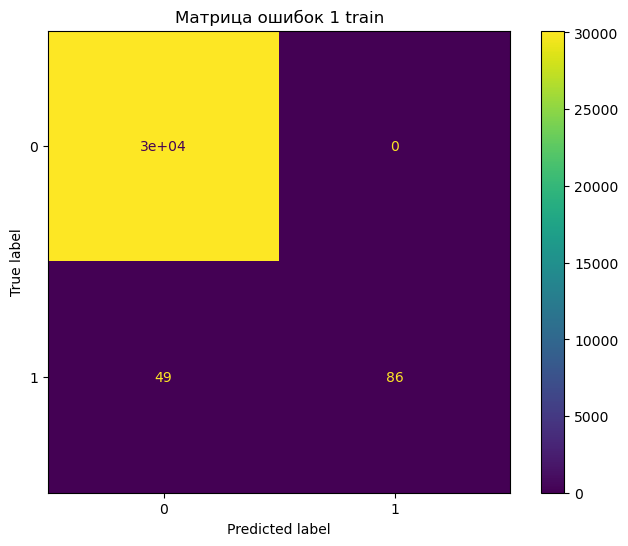

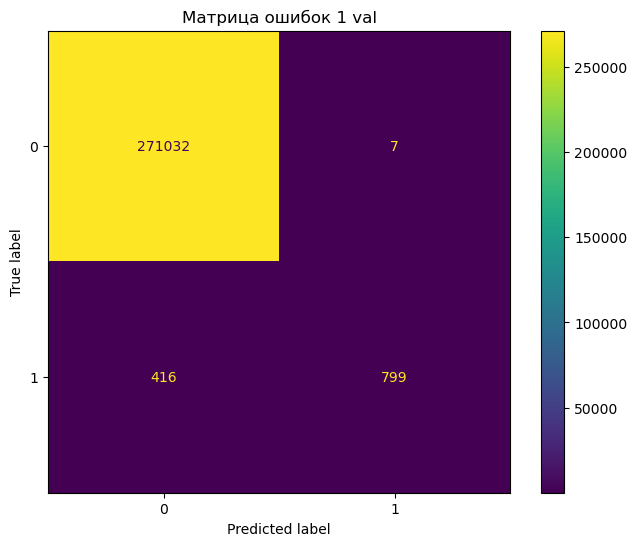

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_train, cb1.predict(X_train))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 train')
display.plot(ax=ax);

conf_matrix = confusion_matrix(y_test, cb1.predict(X_test))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 val')
display.plot(ax=ax);

## Вариант 2. cat 1,2,3,4,5 i20

In [22]:
y_train=data0_train[["cat_id"]].to_pandas()
X_train=data0_train.drop("cat_id","source_name","hash_id","attr_id").to_pandas()

y_test=data0_test[["cat_id"]].to_pandas()
X_test=data0_test.drop("cat_id","source_name","hash_id","attr_id").to_pandas()
cols2=list(X_train.columns)
X_train

,8,6,56,5,61,49,594,598,2952,597,2955,604
0,Holt,2001682889035,---,---,черный,Китай,---,---,---,---,---,---
1,Gcell Electronics,---,---,---,стальной,---,---,---,---,---,---,---
2,WAG,110126617997,---,---,черный,---,---,---,---,---,---,---
3,Vbparts,---,---,---,---,---,---,---,---,---,---,---
4,Netac,6926337233703,UM1,---,серебристый,---,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...
30245,Kenwood,5011423197517,KAX720PL,---,черный; серый,---,---,---,---,---,---,---
30246,NoBrand,3252669858356,Мини,---,синий,---,---,---,---,---,---,---
30247,Mobileocean,---,---,---,---,Китай,---,---,---,---,---,---
30248,Plastinka.com,110118124458,---,---,---,Нидерланды,Funk; Soul; Reggae,LP,CBS,---,---,1972


In [23]:
cb2=CatBoostClassifier(
    iterations=20,
    #text_features=list(X.columns),
    cat_features=list(X_train.columns),
    #cat_features=[8],
    custom_metric=["Accuracy","Precision","F1","Recall"],
    eval_metric="F1",
    random_seed=0,
)
cb2.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb2.save_model("cb2_1-2-3.cbm")
cb2.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.403367
0:	learn: 0.8086957	test: 0.8064359	best: 0.8064359 (0)	total: 52.2ms	remaining: 991ms
19:	learn: 0.9416342	test: 0.9437156	best: 0.9437156 (19)	total: 387ms	remaining: 0us

bestTest = 0.9437156157
bestIteration = 19



,Feature Id,Importances
0,56,22.087054
1,49,18.600735
2,8,14.505662
3,597,14.296281
4,594,10.219063
5,5,10.062623
6,604,4.598183
7,598,3.638086
8,2955,1.786556
9,2952,0.205758


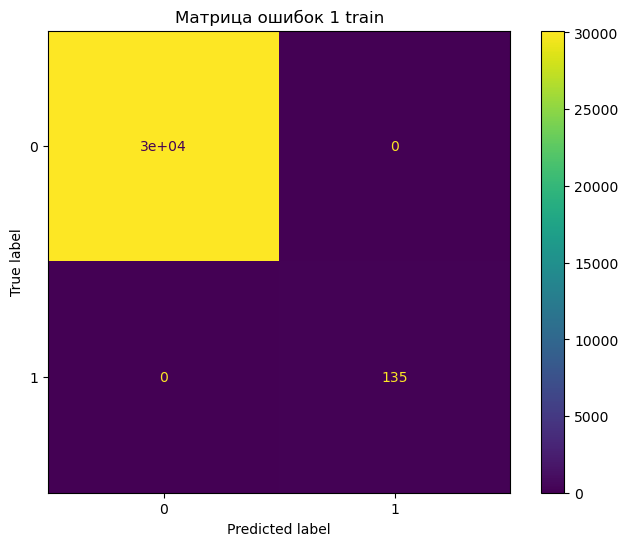

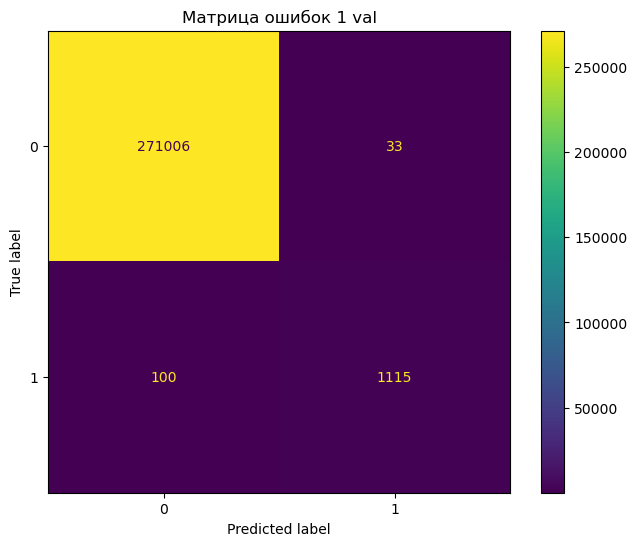

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_train, cb2.predict(X_train))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 train')
display.plot(ax=ax);

conf_matrix = confusion_matrix(y_test, cb2.predict(X_test))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 val')
display.plot(ax=ax);

## Вариант 3. name text i20

In [25]:
y_train=data0_train[["cat_id"]].to_pandas()
X_train=data0_train[["source_name"]].to_pandas()

y_test=data0_test[["cat_id"]].to_pandas()
X_test=data0_test[["source_name"]].to_pandas()

cols3=list(X_train.columns)
X_train

,source_name
0,"Фен для сушки и укладки волос Holt HT-HD-009, ..."
1,"Стальной браслет для Xiaomi Mi Smart Band 8, X..."
2,Системный блок WAG 13410 черный
3,Шлейф для матрицы Vbparts (100120857V)
4,Флешка Netac UM1 16GB 16 ГБ Silver (119958198)
...,...
30245,Насадка-соковыжималка для кухонного комбайна K...
30246,"Мини вентилятор для телефона Lightning, голубой"
30247,"Чехол для Samsung Tab S7 Plus, S8 Plus, Samsun..."
30248,Ballin' Jack - Buzzard Luck Part I Can't Kill ...


In [26]:
cb3=CatBoostClassifier(
    iterations=20,
    text_features=list(X_train.columns),
    custom_metric=["Accuracy","Precision","F1","Recall"],
    eval_metric="F1",
    random_seed=0,
)
cb3.fit(X_train,y_train,
       eval_set=(X_test,y_test),
       verbose=100,
       plot=True)
cb3.save_model("cb3name.cbm")
cb3.get_feature_importance(prettified=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.403367


Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 91.2ms	remaining: 1.73s


Number of the positive class predictions is 0. Setting Precision metric value to the default 0


19:	learn: 0.6504854	test: 0.6105144	best: 0.6105144 (19)	total: 2.07s	remaining: 0us

bestTest = 0.6105144149
bestIteration = 19



,Feature Id,Importances
0,source_name,100.0


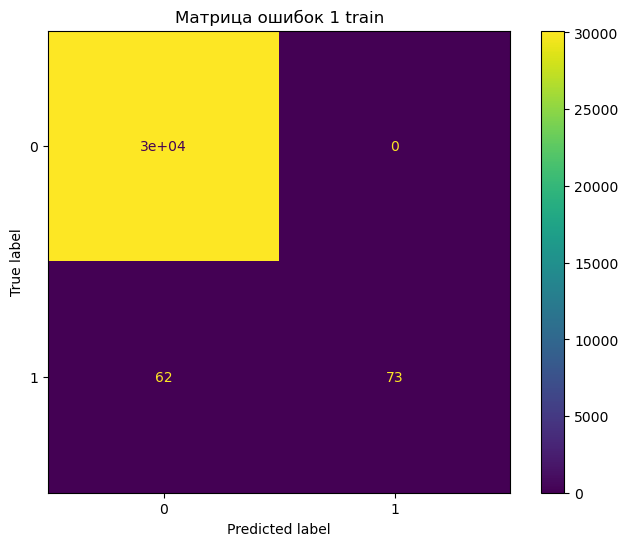

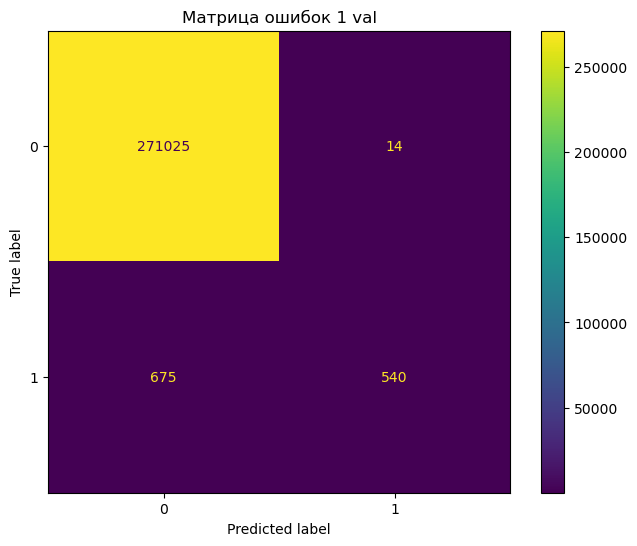

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_train, cb3.predict(X_train))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 train')
display.plot(ax=ax);

conf_matrix = confusion_matrix(y_test, cb3.predict(X_test))
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок 1 val')
display.plot(ax=ax);

In [28]:
data1 = data0.to_pandas()
data1

,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,594,598,2952,597,2955,604
0,46e60d72fa0bb22bce4b33ec0e559624,0,Кофемашина автоматическая Philips EP3246/70,12411 11740 49 11742 14 52 45 12406 8 12407 48...,Philips,---,---,---,---,"Румыния, Китай",---,---,---,---,---,---
1,237718ce171cf6555bc2ca5a5443193e,0,Чехол-бампер MyPads для Xiaomi Redmi Note 11T ...,15 12407 12405 52 12406 11740 14 12411 482 45 ...,MyPads,---,---,---,---,Россия,---,---,---,---,---,---
2,73ea6272c5b66b2bb7ebc17c216e7579,0,Мышь игровая компьютерная FUSION GM-115 оптиче...,8 12407 482 45 12406 15 12405 386 11740 12411 ...,Fusion,---,---,---,---,Китай,---,---,---,---,---,---
3,db85504d507ccd49dd147e804442a504,0,Робот-пылесос Xiaomi Robot Vacuum S10+,12335 35 15 12 12406 14 52 11742 482 12405 124...,Xiaomi,---,---,---,---,Китай,---,---,---,---,---,---
4,9a93e0c99cb97b648fc4fc08d66ed7fb,0,Тонер-картридж NVP совместимый NV-TN-114,15 8 12405 12407 12406 14 45 6 12411 11740 49 ...,NV Print,4660016630736,---,---,---,Китай,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302499,aaadf895b07f461ec8785804840cd730,0,Матрица для ноутбука 17.3 WIDE Glare B173RW01 ...,45 14 12335 12406 49 482 11742 11740 12405 124...,ZeepDeep,---,---,---,---,Китай,---,---,---,---,---,---
302500,cf2e1ff063e930d7fda772dd558647c8,0,Аккумулятор Neovolt для ЭРА Глонасс Renault Ar...,8 49 131 12335 52 11742 12405 14 12411 13456 1...,Neovolt,---,---,---,---,Россия,---,---,---,---,---,---
302501,4a7e977bcf71a465ca8e43d730bf6041,0,Системный блок WAG (AMD Ryzen 7 5700G/GeForce ...,12694 12700 2905 12335 56 97 637 12685 12702 1...,WAG,---,G24-27413418,---,---,---,---,---,---,---,---,---
302502,e379ee41faf4737349d0478703478952,0,"Планшет DIGMA Optima Kids 7 7"""" 2019 1/16GB Mu...",2589 680 8 55 12366 10029 3321 12728 2901 2767...,DIGMA,4630043291422,Optima Kids 7,7,---,---,---,---,---,---,---,---


In [29]:
data1["p1"]=cb1.predict(data1[cols1])
data1["p2"]=cb2.predict(data1[cols2])
data1["p3"]=cb3.predict(data1[cols3])
data1["p_1"]=cb1.predict_proba(data1[cols1])[:,1]
data1["p_2"]=cb2.predict_proba(data1[cols2])[:,1]
data1["p_3"]=cb3.predict_proba(data1[cols3])[:,1]
# Можно сверху этого посадить ещё один катбуст, а сбоку приклеить ЛЛМ, но сегодня этого не будет


data1["p123"]=data1["p1"]+data1["p2"]+data1["p3"]
data1["p_123"]=data1["p_1"]+data1["p_2"]+data1["p_3"]
data1

,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
0,46e60d72fa0bb22bce4b33ec0e559624,0,Кофемашина автоматическая Philips EP3246/70,12411 11740 49 11742 14 52 45 12406 8 12407 48...,Philips,---,---,---,---,"Румыния, Китай",...,---,---,0,0,0,0.057351,0.000620,0.000813,0,0.058784
1,237718ce171cf6555bc2ca5a5443193e,0,Чехол-бампер MyPads для Xiaomi Redmi Note 11T ...,15 12407 12405 52 12406 11740 14 12411 482 45 ...,MyPads,---,---,---,---,Россия,...,---,---,0,0,0,0.057351,0.000560,0.001767,0,0.059677
2,73ea6272c5b66b2bb7ebc17c216e7579,0,Мышь игровая компьютерная FUSION GM-115 оптиче...,8 12407 482 45 12406 15 12405 386 11740 12411 ...,Fusion,---,---,---,---,Китай,...,---,---,0,0,0,0.057351,0.000560,0.001977,0,0.059888
3,db85504d507ccd49dd147e804442a504,0,Робот-пылесос Xiaomi Robot Vacuum S10+,12335 35 15 12 12406 14 52 11742 482 12405 124...,Xiaomi,---,---,---,---,Китай,...,---,---,0,0,0,0.057351,0.000560,0.000813,0,0.058724
4,9a93e0c99cb97b648fc4fc08d66ed7fb,0,Тонер-картридж NVP совместимый NV-TN-114,15 8 12405 12407 12406 14 45 6 12411 11740 49 ...,NV Print,4660016630736,---,---,---,Китай,...,---,---,0,0,0,0.057351,0.000560,0.000813,0,0.058724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302499,aaadf895b07f461ec8785804840cd730,0,Матрица для ноутбука 17.3 WIDE Glare B173RW01 ...,45 14 12335 12406 49 482 11742 11740 12405 124...,ZeepDeep,---,---,---,---,Китай,...,---,---,0,0,0,0.057351,0.000560,0.000806,0,0.058716
302500,cf2e1ff063e930d7fda772dd558647c8,0,Аккумулятор Neovolt для ЭРА Глонасс Renault Ar...,8 49 131 12335 52 11742 12405 14 12411 13456 1...,Neovolt,---,---,---,---,Россия,...,---,---,0,0,0,0.057351,0.000560,0.001681,0,0.059591
302501,4a7e977bcf71a465ca8e43d730bf6041,0,Системный блок WAG (AMD Ryzen 7 5700G/GeForce ...,12694 12700 2905 12335 56 97 637 12685 12702 1...,WAG,---,G24-27413418,---,---,---,...,---,---,0,0,0,0.057351,0.000670,0.000813,0,0.058834
302502,e379ee41faf4737349d0478703478952,0,"Планшет DIGMA Optima Kids 7 7"""" 2019 1/16GB Mu...",2589 680 8 55 12366 10029 3321 12728 2901 2767...,DIGMA,4630043291422,Optima Kids 7,7,---,---,...,---,---,0,0,0,0.059934,0.000764,0.000813,0,0.061512


<Axes: >

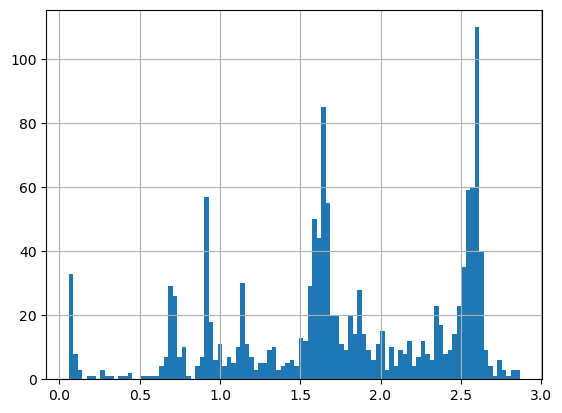

In [30]:
data1[data1["cat_id"]==1]["p_123"].hist(bins=100)

<Axes: >

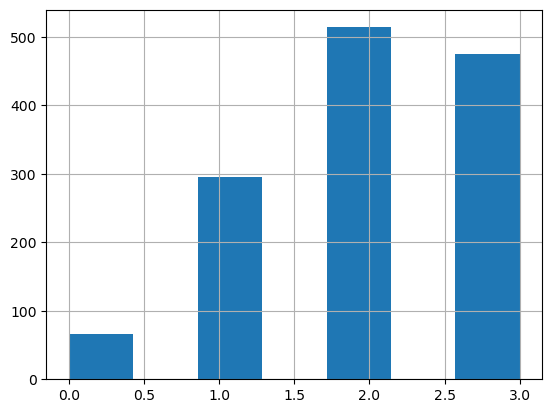

In [31]:
data1[data1["cat_id"]==1]["p123"].hist(bins=7)

/tmp/ipykernel_87450/469442806.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]>0]["p123"].hist(bins=3)


<Axes: >

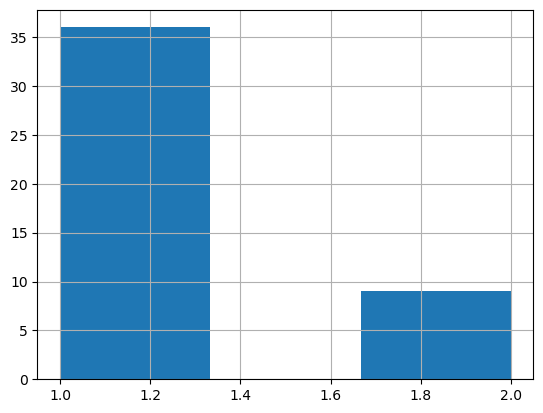

In [32]:
data1[data1["cat_id"]==0][data1["p123"]>0]["p123"].hist(bins=3)

In [33]:
data1[data1["cat_id"]==0][data1["p123"]==3]
#В тройках расхождений нет.

/tmp/ipykernel_87450/2246431814.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==3]


,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123


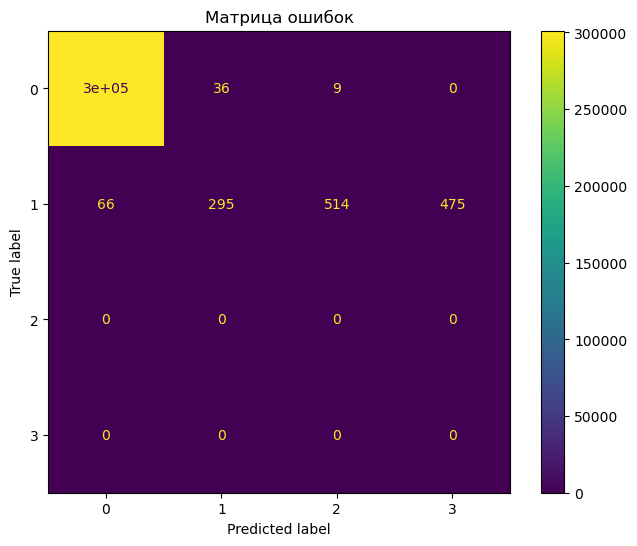

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(data1["cat_id"], data1["p123"])
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(conf_matrix)
ax.set(title='Матрица ошибок')
display.plot(ax=ax);

In [35]:
data1[data1["cat_id"]==0][data1["p123"]==2]
#В двойках расхождения есть. Но это ошибки разметки.
#https://www.ozon.ru/product/sofronitskiy-igraet-shuberta-shubert-list-melnik-i-ruchey-lesnoy-tsar-litaniya-dvoynik-priyut-286861525/
#https://www.shazam.com/album/1471070591/deepening-of-a-groove
#https://zvuk.com/release/13337535
#https://zvuk.com/release/9998760
#https://www.cdvpodarok.ru/products/nikolai-petrov-igraet-baha
#https://plastinka.com/lp/item/307626-lfo-peel-session-tx-20-10-90?ysclid=m87clkf1jr797192903

/tmp/ipykernel_87450/514830638.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==2]


,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
63857,ce8b0c88eda0103e750b073fb7cb03b8,0,LTJ X-PERIENCE Deepening Of A Groove,8 598 6 2952 604 56 12336 49 2955 12335 594,NoBrand,8056234428648,Deepening Of A Groove,---,---,Италия,...,альбом,2019,1,1,0,0.731277,0.686808,0.050722,2,1.468806
99927,760503baa0c1d13fe99e8c7b3cf07630,0,"Гарик Сукачёв (Неприкасаемые, Бригада С) - Вне...",61 8 6 594 598 604 12335 12336 56,Медиа,4690251016330,1 LP,---,черный,---,...,---,2013,1,1,0,0.681870,0.921460,0.005276,2,1.608606
121152,74afca2758883e295a61b9b521032b1a,0,Софроницкий играет Шуберта. Шуберт-Лист. Мельн...,8 12336 6 49 594 597 12335,NoBrand,4603141000319,---,---,---,Евросоюз,...,---,---,1,1,0,0.671191,0.981583,0.000813,2,1.653588
121843,2838bbf2946ac29fd93bb98cf9fa8cc5,0,Инна Вальтер Дымом Лечилась (Исповедь хулиганки),12335 597 6 49 12336 12343 2952 8 12344 594,Медиа,4606344639058,---,---,---,Россия,...,---,---,1,1,0,0.671191,0.882765,0.000813,2,1.554770
193501,a0ee9e6696e6982335bcd6d5ef552e2a,0,Любовь с акцентом,8 6 1303 604 49 12335 594 12336,Медиа,4690241102142,---,---,---,США,...,---,2012,1,1,0,0.681870,0.694666,0.000813,2,1.377350
209977,7360234995196fa98b090978224beb8e,0,Фроггер: Великий квест (Frogger Advance - The ...,8 12336 598 12335 2648 2955,Медиа,---,---,---,---,---,...,стандартное,---,0,1,1,0.071706,0.628485,0.751587,2,1.451777
234133,6ef91e53cd796c9b7b299ea4202f6360,0,The Dungeon of Naheulbeuk: The Amulet of Chaos...,56 12343 8 6 12344 12335 12336,Медиа,3700664528496,The Dungeon of Naheulbeuk: The Amulet of Chaos,---,---,---,...,---,---,0,1,1,0.057351,0.661016,0.930419,2,1.648786
247661,8e2410b4df777f4a55194bfe531edfe5,0,LFO - Peel Session TX 20/10/90 (EP) Warp (307626),6 598 8 594 604 2952 12335 49,Plastinka.com,110105337113,---,---,---,Евросоюз,...,---,2019,1,1,0,0.681870,0.947210,0.003685,2,1.632765
260234,26b47fdb8f6814d989d4fa9951258e4f,0,Николай Петров - И.С. Бах: Английская сюита № ...,12336 6 49 8 594 12335 597 2952,Международная книга - Музыка,4607167792296,---,---,---,Россия,...,---,---,1,1,0,0.671191,0.971005,0.003685,2,1.645882


In [36]:
data1[data1["cat_id"]==0][data1["p123"]==1]

/tmp/ipykernel_87450/1613766942.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==0][data1["p123"]==1]


,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
4393,70ffd1aa298b1ae82b77c5494fa4b053,0,Игра Vampire: The Masquerade: Coteries of New ...,12336 56 8 12335,Funstock,---,Vampire: The Masquerade: Coteries of New York ...,---,---,---,...,---,---,0,0,1,0.057351,0.000670,0.912084,1,0.970105
4548,7b2064e3405cb0f8c85cf64d7993da9d,0,Супермен 2 (Superman 2) (The Death and Return ...,598 2648 12335 10630 8 2955 12336,Медиа,---,---,---,---,---,...,стандартное,---,0,1,0,0.071706,0.628485,0.002018,1,0.702208
15347,1851ef956ef00b7d3e2ab5acf9a13671,0,Игра The Legend of Heroes: Trails of Cold Stee...,2648 8 61 504 594 598 2952 12336 2955 56 12335...,Медиа,810023033318,The Legend of Heroes: Trails of Cold Steel 3,---,стальной,---,...,стандартное,---,0,0,1,0.077700,0.022842,0.751587,1,0.852128
15394,cca8f2850542fd0c0211f77b35a3141c,0,Математический Патруль - Клептоидная Угроза (M...,2648 8 12335 12336 504,NoBrand,---,---,---,---,---,...,---,---,0,0,1,0.073867,0.000627,0.751587,1,0.826080
16774,b59e61c60d0fdb9c1364a0fb14fea30b,0,"CD ТВ-тюнер cdt-9nt372-rf01 , серебристый",15 14 52 11742 12405 482 8 61 12406 12407 45 1...,CD,---,---,---,серебристый,---,...,---,---,0,1,0,0.057351,0.645755,0.000813,1,0.703919
37961,20f703515a96b0e39e05846a20984b20,0,The Elder Scrolls V: Skyrim. Legendary Edition...,8 12336 12335 2648,Медиа,---,---,---,---,---,...,---,---,0,1,0,0.057351,0.645755,0.046482,1,0.749588
43303,5f1eac4c34105ed2bd6e849ff1fa1923,0,Большое приключение Франклина (Franklin's Grea...,598 8 2955 2648 12336 12335,Медиа,---,---,---,---,---,...,стандартное,---,0,1,0,0.071706,0.628485,0.001031,1,0.701221
46431,7b6aa537086b67b4e16cfd6f5945a35d,0,MENDEZ Adrenaline,8 12335 12336 56 6,Медиа,0044001735394,CD,---,---,---,...,---,---,0,1,0,0.057351,0.620802,0.000813,1,0.678966
55930,efaeb767543e3df9340a94c949a8f599,0,Волшебная палочка The Noble Collection Гарри П...,61 96 56 2035 12335 10029 6 12336 8,The Noble Collection,0812370014347,Грегорович,---,бежевый,---,...,---,---,0,0,1,0.057351,0.000670,0.751587,1,0.809608
57884,d9d958a42b8e210ec0a35b20dc4c43e6,0,Messer Fur Frau Muller Нож Для Мечты - Третий ...,12335 8 56 61,Медиа,---,Нож Для Мечты - Третий Сорт - Purple,---,пурпурный,---,...,---,---,0,1,0,0.057351,0.661016,0.228738,1,0.947104


In [37]:
data1[data1["p123"]==1]

,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
8,aeed4326a08b0db34def7ff2a51054fe,1,The Jimi Hendrix Experience Electric Ladyland ...,12335 8 6 12336,Legacy,0190758590417,---,---,---,---,...,---,---,0,0,1,0.057351,0.000627,0.650001,1,0.707979
1120,15eb4a6e7fcb33ea20774eebedd418bc,1,"Stravinsky, The Rite of Spring [London Philhar...",56 12336 8 12335 6 61,Virgin Records,0724356246829,1 CD,---,весенний,---,...,---,---,0,1,0,0.057351,0.862528,0.214421,1,1.134300
1851,01237872c0723b51ca91b371decbe3cc,1,Владимир Крайнев. Сергей Прокофьев. Концерты д...,12336 6 56 12335 8 597,Медиа,4600317122271,2 CD,---,---,---,...,---,---,0,1,0,0.293728,0.802857,0.000806,1,1.097391
2559,00c3c9b9448cb43b1dcc94d1cc1251a5,1,Blackmores Night Fires At Midnight (25th Anniv...,8 12335 6 61,Мистерия Звука,4029759195405,---,---,черный,---,...,---,---,0,1,0,0.057351,0.645755,0.054280,1,0.757386
2835,288426a25c9fd42c8d039d1c8d32ea70,1,"Schutz: Histoire de la Resurrection, Musikalis...",12335 6 8 56 12336,K617,3383510001994,1 CD,---,---,---,...,---,---,0,1,0,0.057351,0.620802,0.093413,1,0.771566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296507,24ba1f7c98d728576d934662c0848d25,1,WEBER: Euranthe - Joan Sutherland; Marianne Sc...,12335 6 8 12336 56,Ponto,8717202250172,2 CD,---,---,---,...,---,---,0,1,0,0.057351,0.862528,0.003685,1,0.923564
298799,83657342aef3d281e08fc0b71212d488,1,Invernizzi / Lazzara / Velardi & Alessandro St...,597 12335 6 8 56 12336,Медиа,8007068216420,1 CD,---,---,---,...,---,---,0,1,0,0.293728,0.802857,0.038912,1,1.135497
301509,99b2e6eb749fe41cc6def0687d92d66a,1,"Loesser, 'Guys & Dolls' {Original Broadway Cas...",12336 597 12335 8 2952 6,Медиа,5055031361045,---,---,---,---,...,---,---,0,1,0,0.293728,0.886168,0.215349,1,1.395245
301899,c7d1caf27e0de7e70daa3073c060939d,1,"ВЫСОЦКИЙ, ВЛАДИМИР: Концерт В ДК """"Юбилейный""""...",12336 12335 8 45,CD,---,---,---,---,---,...,---,---,0,1,0,0.057351,0.645755,0.000813,1,0.703919


In [38]:
data1[data1["cat_id"]==1][data1["p123"]==0]
#Ошибки второго рода. потери.

/tmp/ipykernel_87450/1285577594.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1[data1["cat_id"]==1][data1["p123"]==0]


,hash_id,cat_id,source_name,attr_id,8,6,56,5,61,49,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
3636,252b0390f8ed6e144401193eedf3a4bf,1,Андрей Макаревич И Оркестр Креольского Танго ?...,12344 8 12336 12343 12335 49 6 2952 594,Медиа,4607097190285,---,---,---,Россия,...,---,---,0,0,0,0.229952,0.337745,0.054280,0,0.621978
7264,227ea852bd86569c4f66a24e22304d5c,1,"Hyperion Knight Beethoven: Sonata In C Major, ...",6 8 12335 56,Hyperion Knight,0753088831317,"Beethoven: Sonata In C Major, \",---,---,---,...,---,---,0,0,0,0.057351,0.000670,0.054280,0,0.112301
16701,427297dd55b17f984777d13fef2934a3,1,OST La Donna Il Sesso E Il Superuomo Sandro Br...,598 56 2955 49 2952 6 12335 8 594,IAO,5060672880688,La Donna Il Sesso E Il Superuomo (sandro Brugn...,---,---,Евросоюз,...,альбом,---,0,0,0,0.274910,0.341721,0.079190,0,0.695821
32782,b33bcabe99cf18e800c8a320f1cf13b3,1,"Пристли Д. """"Опасный поворот"""" Спектакль Ленин...",56 12335 6 8 12336,Студия «Звуковая книга»,4608389780993,1 mp3,---,---,---,...,---,---,0,0,0,0.057351,0.000670,0.000813,0,0.058834
40150,d01dcb37f7c672b96c6303e4e1d9db0e,1,"Тома Р. """"Ловушка"""" Исполнители: Ю.Яковлев, В....",56 12336 12335 6 8,Студия «Звуковая книга»,4608389780849,1 mp3,---,---,---,...,---,---,0,0,0,0.057351,0.000670,0.000813,0,0.058834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278956,23be9fda0b9ef52e9e94153fe091a074,1,PINK FLOYD - FULL MOON OVER EUROPE-LOOK AT THE...,12336 56 8 61 12335,ARCHIVE RECORDS & TAPES,---,10CD,---,розовый,---,...,---,---,0,0,0,0.057351,0.000670,0.378414,0,0.436435
283134,2656623158ec6eb4922bfae7653f960b,1,"DR SymfoniOrkestret, Christian Schumann Fantas...",8 12335 6,EuroArts Music International,880242651914,---,---,---,---,...,---,---,0,0,0,0.057351,0.000627,0.054280,0,0.112258
293164,5c8cd69c5fec9fcc9d67c6da69cc4278,1,"ANNA CHIURI, ANNA CHORUS AND CHILDREN’S CHORUS...",6 8 12335 12336,Blu-Ray,8007144578732,---,---,---,---,...,---,---,0,0,0,0.057351,0.000627,0.012450,0,0.070427
294209,b5ae7fd09c3d558f2b91759bb83a8704,1,"BACH, J.S.: Concerto for 2 Violins / MOZART, W...",12336 8 56 12335 6,ICA classics,5060244550124,1 DVD,---,---,---,...,---,---,0,0,0,0.057351,0.000670,0.001977,0,0.059998


## Применение на TEST

In [39]:
%%time
pl.Config.set_tbl_rows(6)
unlabeled=labeled_test.with_columns(pl.col("cat_id").cast(pl.Int16))
unlabeled

unlabeled1 = unlabeled.with_columns((pl.col("attributes").str.slice(3,pl.col("attributes").str.len_chars()-5)
                               ).str.split("},{") )
unlabeled1


unlabeled1 = unlabeled1.explode("attributes"
                         ).with_columns(
    pl.col("attributes").str.extract(r"\"attribute_id\"\"\:(\d+?),", 1).cast(pl.Int16).alias("attr_id"),
    pl.col("attributes").str.extract(r"\"\"attribute_name\"\":\"\"(.+?)\"\"", 1).alias("attr_name"),
    pl.col("attributes").str.extract(r"\"\"attribute_value\"\":\"\"(.+?)\"\"", 1).alias("attr_value"),
    pl.col("attributes").str.extract(r"\"\"attribute_measure\"\":\"\"(.+?)\"\"", 1).alias("attr_measure"),
)
unlabeled1

dataun=unlabeled1.with_columns( pl.col("attr_id").cast(pl.String)
                     ).group_by("hash_id",
                                "cat_id",
                                "source_name"
                 ).agg(pl.col("attr_id").unique()
                      ).with_columns( pl.col("attr_id").list.join(separator=" ")
                                    ).join(
    unlabeled1.filter(pl.col("attr_id").is_in(idatrlist460)
                           ).pivot("attr_id", index="hash_id", values="attr_value", aggregate_function="first"
                                  ),
    how="left",
    on="hash_id"
)
dataun

CPU times: user 13.7 s, sys: 1.22 s, total: 14.9 s
Wall time: 6.36 s


hash_id,cat_id,source_name,attr_id,8,49,6,56,61,5,594,597,598,2952,2955,604
str,i16,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""e5733e5af5dd256acf53abf242438ffe""",1025,"""Флешка OLTRAMAX OM-16GB-250 синий""","""3321 12335 12366 2 55 12336 12340 10029 56 8 61""","""Oltramax""",null,null,"""OM-16GB-250""","""синий""",null,null,null,null,null,null,null
"""d9e4a0425fc8596bfa974b3859920e5f""",1030,"""Системный блок TopComp MG 51986790 Ryzen 5 3600/RX 580/HDD 1TB/RAM 8GB""","""17 55 2767 8 2590 12336 637 2928 12717 3321 12685 12335 2905 104 97""","""TopComp""",null,null,null,null,null,null,null,null,null,null,null
"""3a5ebc0d42b9004a1c5bb92804802c26""",1259,"""Корпус компьютерный Zalman Z3 Plus (Z3 Plus) Black""","""12336 10029 55 61 3321 56 12338 12381 6 12335 8 12343 12344""","""Zalman""",null,"""823884205169""","""Z3 Plus""","""черный""",null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""f28c1952a508f5ee1c1972f6b3156360""",3612,"""EVOBOX START CLASSIC - комплект караоке для небольших помещений, более 80 000 композиций, 2300 предзагружено, оценка исполнения, Live FX""","""52 11740 12335 45 482 12406 14 15 12405 12407 11742 8 12411""","""Studio Evolution""",null,null,null,null,null,null,null,null,null,null,null
"""5cee22d22067b254d1f52d9f9fed1088""",10339,"""Блок питания для ноутбука Amperin AI-SA40B 40Вт для Samsung (013061)""","""56 12335 66 61 3933 8 1404 12336 6""","""Amperin""",null,"""4665310350021""","""AI-SA40B""","""черный""",null,null,null,null,null,null,null
"""cdd81e06b434b81c8dd8c9faf6d01bfc""",1365,"""Универсальный аккумулятор для планшета Digma HIT 3G, Plane 7700T 4G, Dexp Ursus S370, Pocketbook SURFpad, Oysters T72HM 3g, RoverPad Sky S7 и др 94x74…","""12405 45 11740 12407 15 52 12411 11742 12406 49 482 8 12335 14""","""Нет бренда""","""Китай""",null,null,null,null,null,null,null,null,null,null


In [40]:
dataun0 = dataun.filter(pl.col("attr_id")!=""  #TD для товаров без атрибутов нужна будет отдельная доработка
                  ).with_columns(pl.col("cat_id")==460
                  ).with_columns(pl.col("cat_id").cast(pl.Int8)
                                ).fill_null("---")
dataun0

dataun1 = dataun0.to_pandas()
dataun1

,hash_id,cat_id,source_name,attr_id,8,49,6,56,61,5,594,597,598,2952,2955,604
0,e5733e5af5dd256acf53abf242438ffe,0,Флешка OLTRAMAX OM-16GB-250 синий,3321 12335 12366 2 55 12336 12340 10029 56 8 61,Oltramax,---,---,OM-16GB-250,синий,---,---,---,---,---,---,---
1,d9e4a0425fc8596bfa974b3859920e5f,0,Системный блок TopComp MG 51986790 Ryzen 5 360...,17 55 2767 8 2590 12336 637 2928 12717 3321 12...,TopComp,---,---,---,---,---,---,---,---,---,---,---
2,3a5ebc0d42b9004a1c5bb92804802c26,0,Корпус компьютерный Zalman Z3 Plus (Z3 Plus) B...,12336 10029 55 61 3321 56 12338 12381 6 12335 ...,Zalman,---,823884205169,Z3 Plus,черный,---,---,---,---,---,---,---
3,f260b52c7d0f0f6e5694ef47df574fc6,0,Оперативная память ADATA 16Gb DDR4 3600MHz (AX...,8 104 56 12336 12335 12344 12343 97,ADATA,---,---,AX4U36008G18I-DCBK20,---,---,---,---,---,---,---,---
4,b8bce58fa2b16a6cc48621a92a1bfb1a,0,Чехол для AirPods Pro и AirPods Pro 2 (2022) (...,482 45 12406 14 49 11740 11742 12335 52 8 1241...,Нет бренда,Китай,---,---,---,---,---,---,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302425,a51e077d8658a5e7793297f1ea055010,0,Швейная машина Janome L394 белый,12335 12337 8 61 96 12338 6316 12336 56 204 10029,Janome,---,---,L394,белый,---,---,---,---,---,---,---
302426,2b3d82d7bb7254d308f03facbf15d528,0,Внешний беспроводной магнитный аккумулятор для...,12407 49 15 11740 61 12411 14 482 8 45 11742 1...,Yookie,Китай,---,---,зеленый,---,---,---,---,---,---,---
302427,f28c1952a508f5ee1c1972f6b3156360,0,EVOBOX START CLASSIC - комплект караоке для не...,52 11740 12335 45 482 12406 14 15 12405 12407 ...,Studio Evolution,---,---,---,---,---,---,---,---,---,---,---
302428,5cee22d22067b254d1f52d9f9fed1088,0,Блок питания для ноутбука Amperin AI-SA40B 40В...,56 12335 66 61 3933 8 1404 12336 6,Amperin,---,4665310350021,AI-SA40B,черный,---,---,---,---,---,---,---


In [41]:
dataun1["p1"]=cb1.predict(dataun1[cols1])
dataun1["p2"]=cb2.predict(dataun1[cols2])
dataun1["p3"]=cb3.predict(dataun1[cols3])

dataun1["p_1"]=cb1.predict_proba(dataun1[cols1])[:,1]
dataun1["p_2"]=cb2.predict_proba(dataun1[cols2])[:,1]
dataun1["p_3"]=cb3.predict_proba(dataun1[cols3])[:,1]

dataun1["p123"]=dataun1["p1"]+dataun1["p2"]+dataun1["p3"]
dataun1["p_123"]=dataun1["p_1"]+dataun1["p_2"]+dataun1["p_3"]
dataun1[dataun1["p123"]==3]

,hash_id,cat_id,source_name,attr_id,8,49,6,56,61,5,...,2955,604,p1,p2,p3,p_1,p_2,p_3,p123,p_123
526,2be939171017544b87a71f023c812fa7,1,Holst / Vaughan Williams: Choral Music. / Finz...,8 49 594 597 6 12335 12336,Медиа,Евросоюз,0095115942529,---,---,---,...,---,---,1,1,1,0.671191,0.989012,0.957890,3,2.618093
1062,c512fd14eea8c610afe414e7701b2777,1,VARIOUS ARTISTS - Released! The Human Rights C...,2952 12336 6 8 594 597 12335,Медиа,---,4029759132554,---,---,---,...,---,---,1,1,1,0.671191,0.959675,0.615976,3,2.246842
1701,7a303701e5ea017b61baef7495badb81,1,MOBY & THE VOID PACIFIC CHOIR - These Systems ...,6 8 49 12335 12336 594 597,Медиа,Евросоюз,5060236633620,---,---,---,...,---,---,1,1,1,0.671191,0.984851,0.914959,3,2.571001
2691,11b119d9da0d60fcab865e28adfdbbf4,1,Soundtrack / Big Little Lies (Music From Seaso...,604 12335 594 12336 597 8 6 2952 2955 49 598,Abkco,Евросоюз,18771859512,---,---,---,...,альбом,2019,1,1,1,0.787344,0.900715,0.888741,3,2.576799
3749,e474bc70646e624db9c3f7fb985548ef,1,BERIO: Piano Music - Piano Sonata / Sequenza I...,594 56 597 49 12335 6 12336 8,Avie Records,Евросоюз,0822252210422,1 CD,---,---,...,---,---,1,1,1,0.671191,0.958533,0.840131,3,2.469855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295837,3d28bb97cf79356ef92528e631a4e101,1,"Puccini - RITRoVATo, Placido Domingo, Violeta ...",6 49 597 12335 12336 594 8,Медиа,Евросоюз,0028947774556,---,---,---,...,---,---,1,1,1,0.671191,0.989012,0.951223,3,2.611427
296448,0a60a25d47e6e6fdde8b60c02829e6de,1,John Abercrombie Quartet & Marc Copland & Drew...,594 6 8 49 597 12335 12336,Медиа,Евросоюз,0602557233773,---,---,---,...,---,---,1,1,1,0.671191,0.989012,0.935075,3,2.595278
297789,33c792598ba06ba57e3cabd9c7aab629,1,Хачатурян. Симфония №2 ми минор. Фрагменты из ...,12335 8 49 597 12336 6 594,Медиа,Россия,4600317117062,---,---,---,...,---,---,1,1,1,0.671191,0.971065,0.689408,3,2.331663
299481,25c117b2d516abd68b80f9149cdd2742,1,Liszt. Symphonic Poems 7 ['Festklange']. 9 ['H...,594 6 8 49 12336 597 12335,Медиа,Россия,4606344000339,---,---,---,...,---,---,1,1,1,0.671191,0.960377,0.877579,3,2.509148


In [42]:
df=[]
df.append(["Вариант 1"]+confusion_matrix(dataun1["p1"], dataun1["cat_id"]).ravel().tolist())
df.append(["Вариант 2"]+confusion_matrix(dataun1["p2"], dataun1["cat_id"]).ravel().tolist())
df.append(["Вариант 3"]+confusion_matrix(dataun1["p3"], dataun1["cat_id"]).ravel().tolist())
df.append(["Сумма ==3"]+confusion_matrix(dataun1["p123"]==3, dataun1["cat_id"]).ravel().tolist())
df.append(["Сумма >=2"]+confusion_matrix(dataun1["p123"]>=2, dataun1["cat_id"]).ravel().tolist())
df.append(["Сумма >=1"]+confusion_matrix(dataun1["p123"]>=1, dataun1["cat_id"]).ravel().tolist())
df=pd.DataFrame(df,columns=["Вариант","TN","FN","FP","TP"])
df["Accuracy"]=(df["TP"]+df["TN"])/(df["TP"]+df["TN"]+df["FP"]+df["FN"])
df["Precision"]=df["TP"]/(df["TP"]+(df["FP"]))
df["Recall"]=df["TP"]/(df["TP"]+df["FN"])
df["F1"]=2*(df["Recall"]*df["Precision"])/(df["Recall"]+df["Precision"])
df

,Вариант,TN,FN,FP,TP,Accuracy,Precision,Recall,F1
0,Вариант 1,301052,502,11,865,0.998304,0.987443,0.632772,0.771288
1,Вариант 2,301023,118,40,1249,0.999478,0.968968,0.913680,0.940512
2,Вариант 3,301050,756,13,611,0.997457,0.979167,0.446964,0.613762
3,Сумма ==3,301063,915,0,452,0.996975,1.000000,0.330651,0.496976
4,Сумма >=2,301052,386,11,981,0.998687,0.988911,0.717630,0.831708
5,Сумма >=1,301010,75,53,1292,0.999577,0.960595,0.945135,0.952802


In [ ]:
#Область применения имеет значительные ограничения. 
#1)Категория должна иметь размеченные примеры.
#2)У размеченных примеров должны быть проставлены атрибуты.

#Расчет доверительных интервалов не планируется.